In [93]:
import os
print(os.getcwd())

# 작업 디렉토리 변경
os.chdir('/content/drive/MyDrive/Colab Notebooks/graduateProject')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/graduateProject
/content/drive/MyDrive/Colab Notebooks/graduateProject


In [94]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import os
import random

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']

# 다시 임포트
from models import CNN  # CNN 모델 클래스 임포트
from Segdataset import SegDataset  # 데이터셋 로드 클래스
from torch.utils.data import DataLoader, WeightedRandomSampler

In [95]:
# 설정값 정의
data_root = '/content/drive/MyDrive/data/TESS'
save_root = '/content/drive/MyDrive/checkpoints'
num_epochs = 50
learning_rate = 1e-4
batch_size = 128
num_workers = 2
random_seed = 42
model_kind = 'cnn'  # 모델 종류
is_shuffle_dataset = True  # 데이터 셔플 여부
test_split = 0.2  # 테스트 데이터 비율
n_mfcc = 16

In [96]:
# 사용 가능한 디바이스 설정
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"using device : {device}")

using device : cuda


In [97]:
if model_kind == 'rnn':
     model = RNN(n_mfcc)
elif model_kind == 'transformer':
     model = Transformer(n_mfcc)
elif model_kind == 'cnn':
     model = CNN()

In [98]:
train = SegDataset(root=data_root, type='train', n_mfcc=n_mfcc, random_state=random_seed, test_size=test_split)
val = SegDataset(root=data_root, type='val', n_mfcc=n_mfcc, random_state=random_seed, test_size=test_split)

train_iter = torch.utils.data.DataLoader(train, batch_size, shuffle=is_shuffle_dataset, drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(val, batch_size, drop_last=True, num_workers=num_workers)

Read 1581 valid examples
Read 396 valid examples


In [99]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"using device : {device}")

using device : cuda


In [100]:
all_train_epoch_loss = []
all_test_epoch_loss = []
all_test_epoch_accuracy_emotion=[]
model = model.to(device)

pos_weight = torch.tensor([0.75]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)    #Binary Cross Entropy with Logits Loss 활성화 함수 이용

optimizer = optim.Adam(model.parameters(), learning_rate)

In [101]:
for epo in range(num_epochs):
    train_loss = 0
    model.train()  # batch normalization , dropout 활성화

    for index, (mfcc, emotion,_) in enumerate(train_iter):
        mfcc, emotion =mfcc.to(device), emotion.to(device)
        optimizer.zero_grad()
        output_emotion = model(mfcc)

        emotion = emotion.float()

        loss = criterion(output_emotion[:, 0].squeeze(), emotion)
        loss.backward()
        iter_loss = loss.item()
        train_loss += iter_loss
        optimizer.step()

        if np.mod(index, 15) == 0:
            print('epoch {}, {}/{},train loss is {}'.format(epo, index, len(train_iter), iter_loss))

    # test
    test_loss = 0
    correct_emotion = 0
    total=0
    model.eval()
    with torch.no_grad():
        for index, (mfcc, emotion,_) in enumerate(test_iter):
            mfcc, emotion = mfcc.to(device), emotion.to(device)
            optimizer.zero_grad()
            output_emotion = model(mfcc)
            emotion = emotion.float()

            loss = criterion(output_emotion[:, 0].squeeze(), emotion)
            test_loss += loss.item()

            # 이진 분류 결과를 torch.sigmoid를 통해 확률로 변환하고, 0.5 기준으로 분류
            predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
            correct_emotion += (predicted_emotion == emotion).sum().item()
            total += emotion.size(0)
    accuracy_emotion = (correct_emotion / total)
    print('<---------------------------------------------------->')
    print('epoch: %f' % epo)
    print('epoch train loss = %f, epoch test loss = %f,accuracy_emotion =%.3f'
          % (train_loss / len(train_iter), test_loss / len(test_iter),accuracy_emotion))

    if np.mod(epo, 1) == 0:
        torch.save(model.state_dict(), save_root+'/ep%03d-loss%.3f-val_loss%.3f.pth' % (
            (epo + 1), (train_loss / len(train_iter)), (test_loss / len(test_iter)))
                    )
        print('saving checkpoints/model_{}.pth'.format(epo))
    all_test_epoch_accuracy_emotion.append(accuracy_emotion)
    all_train_epoch_loss.append(train_loss / len(train_iter))
    all_test_epoch_loss.append(test_loss / len(test_iter))

epoch 0, 0/12,train loss is 0.5835809111595154
<---------------------------------------------------->
epoch: 0.000000
epoch train loss = 0.599503, epoch test loss = 0.601296,accuracy_emotion =0.448
saving checkpoints/model_0.pth
epoch 1, 0/12,train loss is 0.6069915890693665
<---------------------------------------------------->
epoch: 1.000000
epoch train loss = 0.594587, epoch test loss = 0.597731,accuracy_emotion =0.448
saving checkpoints/model_1.pth
epoch 2, 0/12,train loss is 0.5908048152923584
<---------------------------------------------------->
epoch: 2.000000
epoch train loss = 0.594368, epoch test loss = 0.597344,accuracy_emotion =0.448
saving checkpoints/model_2.pth
epoch 3, 0/12,train loss is 0.5959244966506958
<---------------------------------------------------->
epoch: 3.000000
epoch train loss = 0.593466, epoch test loss = 0.597199,accuracy_emotion =0.448
saving checkpoints/model_3.pth
epoch 4, 0/12,train loss is 0.6016936898231506
<------------------------------------

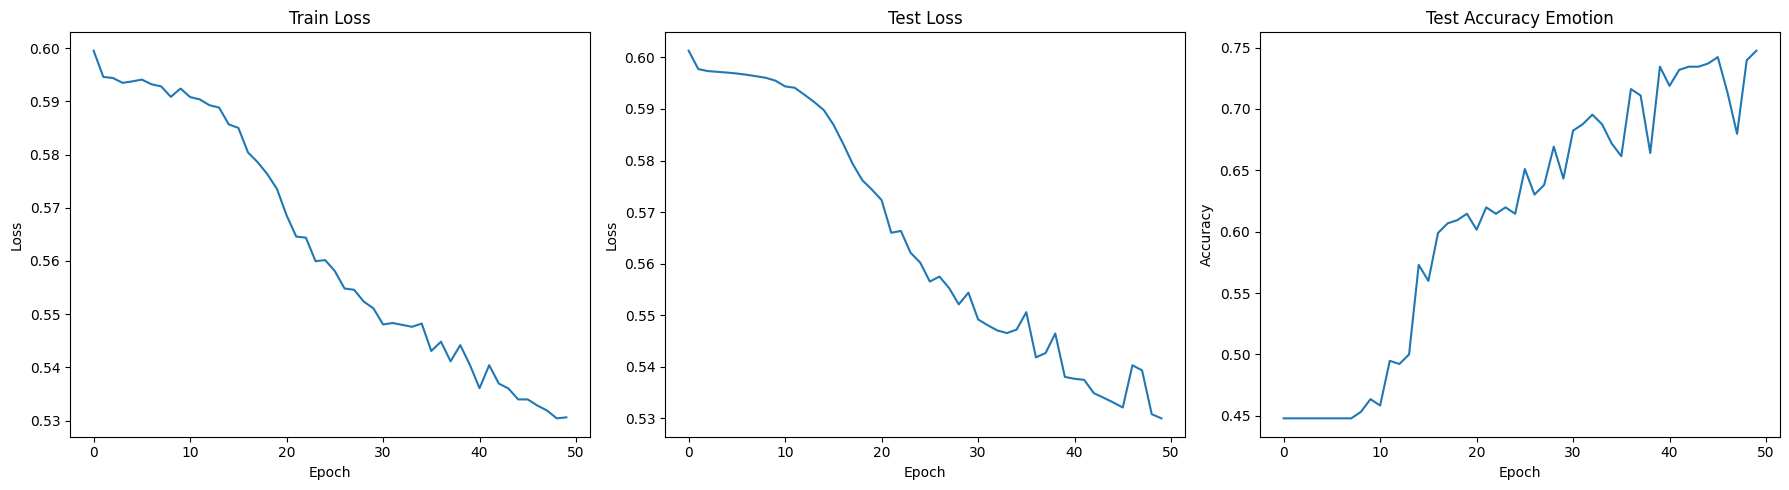

In [103]:
import matplotlib.pyplot as plt

# 여러 그래프를 한 화면에 출력
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1행 3열로 그래프 배치

# 학습 손실 그래프
axs[0].plot(all_train_epoch_loss)
axs[0].set_title('Train Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# 테스트 손실 그래프
axs[1].plot(all_test_epoch_loss)
axs[1].set_title('Test Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

# 테스트 정확도 그래프
axs[2].plot(all_test_epoch_accuracy_emotion)
axs[2].set_title('Test Accuracy Emotion')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 출력
plt.savefig(save_root + '/training_results.png')  # 하나의 파일로 저장
plt.show()  # 화면에 출력
